In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [68]:
from CompoTree import ComponentTree, Radicals, TSVariants, CharLexicon, CTFounds
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import numpy.linalg as la

In [4]:

kv = KeyedVectors.load("../data/fasttext-zh-sw/fasttext-zh-sw.kv")
kv.init_sims()

In [5]:
ctree = ComponentTree.load()
radicals = Radicals.load()
tsvars = TSVariants.load()
lexicon = CharLexicon.load()


In [6]:
ctree.query("灘", use_flag="first")[0].children

[['氵'], [<⿰:[<⿱:['廿'][<⿻:['口'][<⿻:[<⿱:['一']['一']>]['人']>]>]>]['隹'](GTKV)>]]

In [7]:
for w in lexicon:
    print(w)
    break

筠


In [8]:
from collections import defaultdict
chars_set = set()
compo_set = set()
decompo_set = set()
compo_items = set()
for word in lexicon:  
    if word not in kv.vocab:
        continue
        
    try:
        ortho_x = ctree.query(word, 
                          max_depth=1, 
                          use_flag="shortest")[0]
    except:
        print(word)
        continue
            
    if isinstance(ortho_x, str):
        compos = [ortho_x]
    else:
        compos = [str(x) for x in 
                  ortho_x.components(use_flag="shortest")]
        
    compo_seq = tuple(sorted(compos))     
    if compo_seq not in compo_items and len(compos) == 2:
        compo_items.add(compo_seq)
    else:        
        continue
    
    chars_set.add(word)    
    if tsvars.is_simplified(word):
        compos = [x+"_s" for x in compos]
    else:
        compos = [x+"_t" for x in compos]
       
    compo_set |= set(compos)
    decompo_set |= set((word, str(compo_x))
                       for compo_x in compos)    

In [9]:
len(chars_set), len(compo_set), len(decompo_set)

(6156, 2498, 12292)

## Component semantic matrix

### An underlying assumption: Character meanings are *linearly combinations* of their composing components' semantics
$$
C_{k\times d}: \textrm{Component semantic matrix, k components $\times$ d vector size }\\
Z_{n\times d}: \textrm{Character semantic matrix, n characters $\times$ d vector size }\\
D_{n\times k}: \textrm{Decomposition matrix, n characters $\times$ k components}\\
Z = D\cdot C\\
C = (D^\top D)^{-1}D^\top Z
$$

## Limitations
* The semantic vectors of single character words in FastText are less stable
* The components in the matrix (so far) is not position-awared.

## Component Matrix

In [11]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [12]:
char_enc = LabelEncoder()
compo_enc = LabelEncoder()
char_enc.fit(list(chars_set))
compo_enc.fit(list(compo_set))

LabelEncoder()

In [13]:
n_char = len(char_enc.classes_)
n_compo = len(compo_enc.classes_)

In [14]:
decompo_matrix = np.zeros((n_char, n_compo), dtype=np.int32)
decompo_matrix.shape

(6156, 2498)

In [15]:
for item_x in decompo_set:
    char_idx = char_enc.transform([item_x[0]])[0]
    compo_idx = compo_enc.transform([item_x[1]])[0]
    decompo_matrix[char_idx, compo_idx] = 1

In [16]:
aa = LabelEncoder()
aa.fit(["a", "b", "c"])

LabelEncoder()

In [17]:
sel_compo_idx = decompo_matrix.sum(axis=0)>1
sel_compo_enc = LabelEncoder()
sel_compo_enc.fit(compo_enc.classes_[sel_compo_idx])
decompo_matrix_reduced = decompo_matrix[:, sel_compo_idx]
print(decompo_matrix_reduced.shape)
la.matrix_rank(decompo_matrix_reduced)

(6156, 1407)


1407

In [18]:
## Character semantic vector
word_kv_idxs = []
for word in char_enc.classes_:
    word_kv_idxs.append(kv.vocab[word].index)
char_ft = kv.vectors_norm[word_kv_idxs, :]
char_ft.shape

(6156, 300)

In [19]:
import numpy as np
import numpy.linalg as la

D = decompo_matrix_reduced
Z = char_ft
print("D, Z: ", D.shape, Z.shape)
compo_ft = la.inv(D.T.dot(D)).dot(D.T).dot(Z)

D, Z:  (6156, 1407) (6156, 300)


In [20]:
Zhat = D.dot(compo_ft)
R = Z.dot(Zhat.T)

In [21]:
def query_component(compo, is_trad=True):
    if is_trad is not None:
        compo = compo + ("_t" if is_trad else "_s")
    compo_vec = compo_ft[sel_compo_enc.transform([compo])[0]]
    return compo_vec

In [110]:
from tabulate import tabulate
from itertools import chain
def list_compo_neighbors(compo_t, compo_s):
    trads = kv.similar_by_vector(query_component(compo_t, is_trad=True))
    simps = kv.similar_by_vector(query_component(compo_s, is_trad=False))
    trad_neighbors = CTFounds(ctree.find(compo_t, max_depth=1))\
                        .traditional_only()\
                        .filter_with_lexicon(lexicon).tolist()
    simp_neighbors = CTFounds(ctree.find(compo_s, max_depth=1))\
                        .simplified_only()\
                        .filter_with_lexicon(lexicon).tolist()
    print(f"Trad neighbors({len(trad_neighbors)}): ", 
           ",".join([x[0] for x in trad_neighbors][:10]))
    print(f"Simp neighbors({len(simp_neighbors)}): ", 
           ",".join([x[0] for x in simp_neighbors][:10]))
    
    if trads and simps:
        print(tabulate((
                list(chain(t, s))
                for t, s 
                in zip(trads, simps)), 
                headers=["Trad", "sim", "Simp", "sim"]))
    elif trads:
        print(tabulate(trads, headers=["Trad", "sim"]))
    elif simps:
        print(tabulate(simps, headers=["Simp", "sim"]))
    else:
        print("trads and simps are both missing")
    return    



## Orthographical neighbors and semantic space neighbors

In [111]:
list_compo_neighbors("女", "女")

Trad neighbors(107):  好,娥,始,嬸,嫉,娶,妄,妺,妻,姣
Simp neighbors(16):  妇,娇,婶,娄,奸,娴,妩,嬷,娱,婵
Trad         sim  Simp         sim
------  --------  ------  --------
妹      0.98588   婶      0.985482
媚      0.985726  嬷      0.983757
妻      0.985599  敫      0.982878
姊      0.984483  嫫      0.982786
逅      0.983553  鐏      0.981498
嫂      0.98324   姘      0.981453
婷      0.983083  祃      0.981376
綺      0.982885  齹      0.980913
竟      0.982851  婵      0.980891
玔      0.982789  娆      0.980836


In [112]:
list_compo_neighbors("艹", "艹") 

Trad neighbors(186):  菠,蘸,蕤,薰,蔣,芎,菊,蒜,萍,蘇
Simp neighbors(39):  萧,荟,苏,萨,葱,莲,薮,荫,荣,藓
Trad         sim  Simp         sim
------  --------  ------  --------
玉      0.985763  荣      0.986638
柏      0.98392   贤      0.985357
秋      0.983803  陈      0.985349
乃      0.983442  许      0.985107
竟      0.983216  云      0.985003
如      0.983167  寿      0.984808
遂      0.983139  黄      0.984578
芳      0.983045  鸿      0.984416
露      0.982954  吴      0.984327
亦      0.982551  则      0.984007


In [113]:
list_compo_neighbors("貝", "头")

Trad neighbors(54):  購,貽,賀,賃,買,費,員,資,貫,寶
Simp neighbors(3):  买,头,实
Trad         sim  Simp         sim
------  --------  ------  --------
卻      0.985784  买      0.990016
還      0.984368  实      0.982377
雖      0.984065  卖      0.976
當      0.983598  购      0.97066
願      0.983596  当      0.969497
則      0.983449  却      0.969027
買      0.983167  还      0.968702
貴      0.983115  则      0.968679
說      0.983106  刚      0.968421
爲      0.983011  给      0.968415


In [71]:
CTFounds(ctree.find("勾", max_depth=1)).simplified_only().tolist()

[('钩', [⿰1钩]), ('构', [⿰1构]), ('沟', [⿰1沟]), ('购', [⿰1购])]

In [87]:
tsvars.convert("學")

['学']

In [89]:
ctree.query("学", max_depth=1)

[<⿳:['𭕄']['冖']['子']>]

In [114]:
list_compo_neighbors("又", "又")

Trad neighbors(15):  取,反,受,支,雙,馭,叟,叉,叡,叔
Simp neighbors(19):  鸡,叹,对,凤,汉,圣,驭,难,观,变
Trad         sim  Simp         sim
------  --------  ------  --------
而      0.984034  却      0.987573
即      0.983707  虽      0.986946
亦      0.983202  则      0.986583
取      0.982846  对      0.985842
如      0.982046  说      0.985663
也      0.982001  当      0.985573
之      0.981641  与      0.984682
便      0.981625  贤      0.984341
以      0.981548  还      0.984294
和      0.981331  许      0.98427


In [115]:
list_compo_neighbors("幾", "几")

Trad neighbors(6):  譏,磯,璣,嘰,機,饑
Simp neighbors(12):  凭,凤,饥,几,讥,叽,风,矶,秃,玑
Trad         sim  Simp         sim
------  --------  ------  --------
轢      0.968187  凤      0.981599
澠      0.965689  云      0.974678
肈      0.965199  窜      0.973051
慱      0.964905  鸣      0.973001
睎      0.964685  虽      0.972802
瀜      0.96439   风      0.97261
憊      0.964198  头      0.972396
蕚      0.963757  鹤      0.972001
刼      0.96367   说      0.971916
穚      0.963555  飞      0.971903


In [90]:
simp_radicals = [x+"_s" for x in radicals.ts_radicals.keys()]
trad_radicals = [x+"_t" for x in radicals.ts_radicals.values()]
targets = [("又_s", "又_t"), ("几_s", "几_t")]

rois = []
for s, t in targets:
    if s in sel_compo_enc.classes_ and \
       t in sel_compo_enc.classes_:
        rois += [s, t]
print("rois count: ", len(rois))
print(rois)
for srad, trad in zip(simp_radicals, trad_radicals):
    if srad in sel_compo_enc.classes_ and \
       trad in sel_compo_enc.classes_:
        rois += [srad, trad]
print("rois count: ", len(rois))

rois count:  4
['又_s', '又_t', '几_s', '几_t']
rois count:  44


In [91]:
roi_vectors = np.zeros((len(rois), compo_ft.shape[1]), dtype=np.float)
for roi_idx, roi_x in enumerate(rois):
    roi_vectors[roi_idx] = query_component(roi_x, is_trad=None)

In [92]:
roi_vectors.shape

(44, 300)

In [93]:
from sklearn.decomposition import PCA
roi_pca = PCA(3)
roi_2d = roi_pca.fit_transform(roi_vectors)

In [94]:
from matplotlib import font_manager

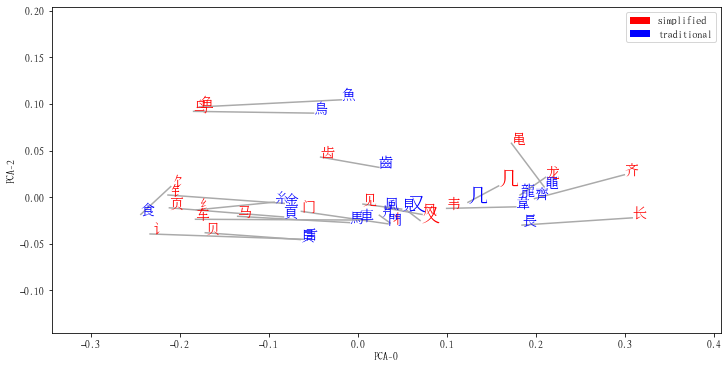

In [95]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "HanaMinA" 
plt.figure(figsize=(12,6))
idx_iter = iter(range(len(rois)))
dim_x = 0
dim_y = 2
for s_idx, t_idx in zip(*([idx_iter]*2)):
    s_compo = rois[s_idx].split("_")[0]
    t_compo = rois[t_idx].split("_")[0]
    
    text_args = dict(fontsize=14)
    if (rois[s_idx], rois[t_idx]) in targets:
        text_args["fontsize"]=20
    
    plt.text(roi_2d[s_idx, dim_x], roi_2d[s_idx, dim_y], 
             s_compo, color="red", **text_args)
    plt.text(roi_2d[t_idx, dim_x], roi_2d[t_idx, dim_y], 
             t_compo, color="blue", **text_args)
    plt.plot(roi_2d[[s_idx, t_idx], dim_x], roi_2d[[s_idx, t_idx], dim_y], color='#AAAAAA')
coord_max = roi_2d.max(axis=0)+0.1
coord_min = roi_2d.min(axis=0)-0.1
plt.xlim(coord_min[dim_x], coord_max[dim_x])
plt.ylim(coord_min[dim_y], coord_max[dim_y])
plt.xlabel(f"PCA-{dim_x}")
plt.ylabel(f"PCA-{dim_y}")
from matplotlib.patches import Patch
h_legends = [Patch(facecolor="red", label="simplified"),
             Patch(facecolor="blue", label="traditional")]
plt.legend(handles=h_legends, loc="upper right")

In [38]:
ctree.query("鎂", max_depth=1)

[<⿰:['金']['美']>]

In [48]:
ctree.find("心")

|(慮): ⿸
..|(虍): ⿸
....|(--): ⿱
......| ⺊
......| ②
....| 七
..|(思): ⿱
....| 田
....| 心
